# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [1]:
import os

from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.preprocessing.preprocessor import make_original_dataframe, make_resized_dataframe, make_noised_dataframe
from debruiteur.noise.noise import GaussianNoise, PoissonNoise, UniformNoise, SaltPepperNoise, SquareMaskNoise, SpeckleNoise
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.filters import wiener_filter, laplacian_filter, gaussian_weighted_substract_filter, mean_filter, median_filter, conservative_filter, fft_filter
from debruiteur.statistics.statistics import compute_noise_reduction_method_statistics, compute_noise_type_statistics
from debruiteur.metrics.metrics import metrics_example

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=20),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
]

### Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \dot \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

C:\Users\Romain\Desktop\ProjetHeArc\ledebruiteur\debruiteur\metrics\metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim = metrics.structural_similarity(orignal_img, noised_img)


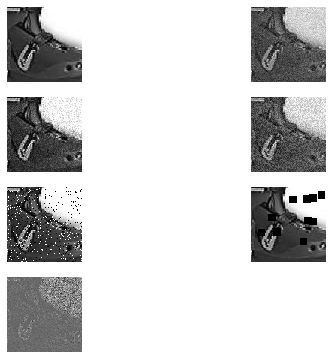

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,393.450194,0.146075,22.181906,0.435446
1,PoissonNoise,246.909700,0.115718,24.205422,0.499590
2,UniformNoise,3377.953505,0.428014,12.844267,0.303333
3,SaltPepperNoise,2358.355900,0.357631,14.404710,0.274452
4,SquareMaskNoise,3347.464700,0.426078,12.883644,0.795911
5,SpeckleNoise,19178.227517,1.019847,5.302719,0.130783


In [4]:
metrics_example(df_noised, noise_class_list)

### Create data generator

In [5]:
stats_gen = DataGenerator(df_noised[0:20], batch_size=20)

### Load models

In [6]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

C:\Users\Romain\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\core.py:986: UserWarning: debruiteur.models.gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Noise reduction methods

In [7]:
noise_reduction_methods = [('Wiener Filter', lambda img: wiener_filter(img * 255)),
                           ('Laplacian Filter', lambda img: laplacian_filter(img * 255)),
                           ('Gaussian Weighted Filter', lambda img: gaussian_weighted_substract_filter(img * 255)),
                           ('Mean Filter', lambda img: mean_filter(img * 255)),
                           ('Median Filter', lambda img: median_filter(img * 255)),
                           ('Conservative Filter', lambda img: conservative_filter(img * 255)),
                           ('FFT FIlter', lambda img: fft_filter(img * 255)),
                           ('Convolutional Autoencoder', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),
                           ('Generative Adversarial Network', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255)]

### Noise reduction methods metrics averaged on all kind of noises

In [8]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,MSE,NRMSE,PSNR,SSIM
Wiener Filter,2731.647961,0.393990,14.010690,0.378300
Laplacian Filter,1916.321968,0.329874,15.644622,0.229527
Gaussian Weighted Filter,3785.518830,0.434510,13.791927,0.509854
Mean Filter,1635.320741,0.301172,16.505979,0.377232
Median Filter,1537.884375,0.286800,17.093937,0.430074
Conservative Filter,1925.468565,0.302188,17.252503,0.606150
FFT FIlter,1476.228592,0.276367,17.526915,0.560725
Convolutional Autoencoder,3999.794254,0.466037,12.999344,0.158589
Dense Autoencoder,5614.209777,0.575628,10.723074,0.007777
Generative Adversarial Network,2666.595186,0.372774,15.092578,0.495305


### Noise reductions methods for each noise type

In [9]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Wiener Filter,0.365297,0.439265,0.368163,0.361167,0.375377,0.098050
Laplacian Filter,0.202186,0.258302,0.203530,0.214901,0.246182,0.050665
Gaussian Weighted Filter,0.606800,0.609703,0.504196,0.338919,0.748518,0.199323
Mean Filter,0.333178,0.427079,0.333632,0.351077,0.394182,0.079382
Median Filter,0.359285,0.461340,0.337793,0.528402,0.445663,0.084451
Conservative Filter,0.622308,0.711551,0.541872,0.513409,0.822222,0.174879
FFT FIlter,0.581049,0.667384,0.543108,0.462770,0.650882,0.159203
Convolutional Autoencoder,0.167716,0.172320,0.168044,0.133409,0.150222,0.021601
Dense Autoencoder,0.007774,0.008653,0.007874,0.008415,0.008447,0.004582
Generative Adversarial Network,0.480409,0.568845,0.464198,0.376577,0.544625,0.112739


In [10]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "PSNR")

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Wiener Filter,14.880523,16.212585,14.982917,14.865185,13.225442,10.840270
Laplacian Filter,16.040646,17.857965,16.376778,17.333576,14.894263,11.635810
Gaussian Weighted Filter,18.864247,18.858531,17.034298,11.200189,14.486541,11.237889
Mean Filter,16.822601,19.311155,17.173182,18.492559,15.462998,11.688668
Median Filter,17.089311,20.053812,17.467226,20.111159,14.789964,11.818908
Conservative Filter,19.042189,24.123060,18.648866,15.871495,16.533759,11.659057
FFT FIlter,18.322265,22.627326,18.805312,17.775867,16.827925,11.789253
Convolutional Autoencoder,13.409937,13.370377,13.338085,12.137443,11.794626,9.763718
Dense Autoencoder,10.753447,10.720120,10.755543,10.733389,10.729361,10.474264
Generative Adversarial Network,13.714063,15.649954,14.274249,13.559457,13.237133,9.697254


In [11]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "MSE")

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Wiener Filter,2122.651107,1597.752275,2093.640118,2204.452574,2950.050553,5445.198581
Laplacian Filter,1629.422915,1116.976339,1534.779833,1249.008184,2116.509339,4512.880444
Gaussian Weighted Filter,859.531683,855.935488,1300.544932,5017.344533,2185.923599,4776.240225
Mean Filter,1413.495001,803.796035,1279.611350,955.436753,1868.141767,4507.730698
Median Filter,1276.454931,695.111325,1188.404880,694.925431,1845.476535,4500.253272
Conservative Filter,823.579539,253.557592,896.858665,1691.240875,1685.109475,4561.440723
FFT FIlter,928.852935,366.207030,870.077555,1069.325510,1465.699813,4391.486707
Convolutional Autoencoder,2995.978380,3050.839873,3023.552503,3988.468475,4317.664209,7181.935366
Dense Autoencoder,5569.921779,5617.069363,5566.815956,5604.576699,5608.436378,5969.286586
Generative Adversarial Network,2823.205592,1802.541278,2439.678809,2888.844554,3094.405465,6911.947326


In [12]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "NRMSE")

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Wiener Filter,0.356834,0.304304,0.352150,0.359246,0.413897,0.560874
Laplacian Filter,0.315122,0.256637,0.301963,0.271863,0.350626,0.515087
Gaussian Weighted Filter,0.225786,0.224399,0.277537,0.545664,0.377090,0.536645
Mean Filter,0.290411,0.217419,0.275616,0.237822,0.330078,0.515335
Median Filter,0.276425,0.200708,0.265578,0.200350,0.346201,0.516447
Conservative Filter,0.219690,0.121273,0.230550,0.316375,0.297111,0.515385
FFT FIlter,0.235234,0.146881,0.226993,0.256643,0.283447,0.506579
Convolutional Autoencoder,0.421984,0.425003,0.423509,0.488644,0.500161,0.622506
Dense Autoencoder,0.573332,0.575739,0.573453,0.575113,0.576125,0.594645
Generative Adversarial Network,0.405967,0.325585,0.379447,0.407224,0.423185,0.644362
